# "Multilingual Sequence Classifaction with the MBart Family"
> "Need to do some multi-lingual sequence classification? Look no further, at least if you want to use MBart and/or the MBart-50 variety of models.  Working against the `amazon_reviews_multi` dataset I'll show you how to use the `blurr` library to configure the huggingface objects, build DataLoaders, and train a model that you can use for classifying German text.  I'll throw in a bit of the inference code so that you can see how easy `blurr` makes it to use your trained model to boot.  Let's go ...

- toc: false
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Wayde Gilliam
- categories: [blurr, huggingface, fastai, multilingual, sequence classification]
- hide: true
- search_exclude: true
- show_tags: false
- permalink: temp-posts/mbart

In [1]:
!pip install ohmeow-blurr -q
!pip install datasets -q

In [2]:
from fastai.text.all import *
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification

from blurr.utils import BLURR
from blurr.data.core import *
from blurr.modeling.core import *

In [3]:
from blurr import __version__ as blurr_version
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using blurr {blurr_version}')
print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using blurr 0.0.25
Using pytorch 1.8.1+cu101
Using fastai 2.3.1
Using transformers 4.6.1


## Data

In [4]:
trn_ds, val_ds, tst_ds = load_dataset("amazon_reviews_multi", "de", split=['train', 'validation', 'test'])

Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


In [5]:
trn_df = pd.DataFrame(trn_ds)
val_df = pd.DataFrame(val_ds)
tst_df = pd.DataFrame(tst_ds)

> Important: Use a subset of the data when building your model to speed up developement time!


After you got everything, throw the full dataset at it and go get some coffee :)

In [6]:
# testing with a subset ... (comment out to train on full dataset!!!)

# this won't work because the rows are ordered by our targets!
# trn_ds, val_ds = load_dataset("amazon_reviews_multi", "de", split=['train[:10%]', 'validation[:10%]'])

trn_df = trn_df.sample(frac=0.05)
val_df = val_df.sample(frac=0.05)

In [7]:
trn_df['is_valid'] = False; val_df['is_valid'] = True
df = pd.concat([trn_df, val_df])

print(len(trn_df), len(val_df), len(df))

200000 5000 205000


In [8]:
trn_df.head()

,language,product_category,product_id,review_body,review_id,review_title,reviewer_id,stars,is_valid
0,de,sports,product_de_0865382,Armband ist leider nach 1 Jahr kaputt gegangen,de_0203609,Leider nach 1 Jahr kaputt,reviewer_de_0267719,1,False
1,de,home_improvement,product_de_0678997,In der Lieferung war nur Ein Akku!,de_0559494,EINS statt ZWEI Akkus!!!,reviewer_de_0783625,1,False
2,de,drugstore,product_de_0372235,"Ein Stern, weil gar keine geht nicht. Es handelt sich um gebraucht Waren, die Stein haben so ein Belag drauf, wo man sich dabei denken kann, dass jemand schon die benutzt und nicht Mal richtig gewaschen. Bei ein paar ist die Qualität Mangelhaft, siehe Bild. Ein habe ich ausprobiert, richtig gewaschen, dann verfärbt sich..... Wärme halt nicht lange. Deswegen wird es zurückgeschickt.",de_0238777,Achtung Abzocke,reviewer_de_0911426,1,False
3,de,drugstore,product_de_0719501,"Dachte, das wären einfach etwas festere Binden, vielleicht größere Always. Aber die Verpackung ist derartig riesig - wie als hätte man einen riesigen Karton Windeln gekauft... nicht das, was ich wollte ;-)",de_0477884,Zu viel des Guten,reviewer_de_0836478,1,False
4,de,toy,product_de_0022613,Meine Kinder haben kaum damit gespielt und nach 6 Monaten riss es an der Naht obwohl ich sehr leichte Kinder habe.,de_0270868,Qualität sehr schlecht,reviewer_de_0736276,1,False


In [9]:
unique_tgt_vals = trn_df.stars.value_counts()
print(unique_tgt_vals)

labels = sorted(list(df.stars.unique()))
print(labels)

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64
[1, 2, 3, 4, 5]


## huggingface objects

In [10]:
model_name = "facebook/mbart-large-50"
model_cls = AutoModelForSequenceClassification
hf_tok_kwargs = {'src_lang': 'de_DE', 'tgt_lang': 'de_DE'}

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name,  
                                                                  model_cls=model_cls,  
                                                                  tokenizer_kwargs=hf_tok_kwargs, 
                                                                  config_kwargs={'num_labels': len(labels)})

print('arch: ', type(hf_arch))
print('config: ', type(hf_config))
print('tokenizer: ', type(hf_tokenizer))
print('model: ', type(hf_model))

arch:  <class 'str'>
config:  <class 'transformers.models.mbart.configuration_mbart.MBartConfig'>
tokenizer:  <class 'transformers.models.mbart.tokenization_mbart50_fast.MBart50TokenizerFast'>
model:  <class 'transformers.models.mbart.modeling_mbart.MBartForSequenceClassification'>


> Important: Always good to look into the config as you'll often find good defaults to use in your training and inference!

In [11]:
hf_config

MBartConfig {
  "_name_or_path": "facebook/mbart-large-50",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "MBartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LAB

## DataLoaders

In [12]:
# 3 lines!  Nice!!!
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=256), CategoryBlock)
dblock = DataBlock(blocks=blocks, get_x=ColReader('review_body'), get_y=ColReader('stars'), splitter=ColSplitter())

dls = dblock.dataloaders(df, bs=4)

> Important: It's almost always useful to look at the `shape` of things in your batches (esp. when debugging)

For example, when running on a colab GPU I kept getting CUDA OOM even with a batch size of just 4.  So I looked at the input_ids and saw that they were over 1,000 tokens long in some batches.  So I adjusted the `max_length` above to ensure they weren't longer that 128 characters and voila, you have the tutorial before you now.

Of course, you should run this with the biggest batch size and sequence size your GPU(s) will support.

In [13]:
xb, yb = dls.one_batch()
xb['input_ids'].shape

torch.Size([4, 256])

In [14]:
# what does human friendly data look like?
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=1500)

,text,category
0,So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So,4
1,"Leider gehört das P20 zu den Geräten, bei denen man mit Panzerglas nicht glücklich wird, außer es ist massiv zu klein geschnitten. Ansonsten tritt leider mehr oder weniger der Effekt auf, dass die Kanten des Panzerglas abheben und nicht anhaften, da das Display am Rand eine leichte Krümmung aufweist. Das dies aber so massiv ausfällt, hatte ich nicht erwartet - zumal die Produktfotos (offensichtlich überarbeitet) eine vollflächige Anhaftung und gleichmäßige Optik suggerieren. Mir ist es eindeutig zu viel, zumal sich unter dem abhebenden Rand bereits dreck sammelt und die die Touchbedienung am Rand des Displays bereits einschränkt. Ich habe das Glas wieder runter gemacht und bin derzeit bei dem Glas von Spigen, dass das Problem jedoch zumindest an den seitlichen Rändern ebenfalls - wenn auch nicht so massiv - aufweist. Alles in allem kann ich nur von dem Kauf abraten, wenn man mit der Problematik nicht leben kann, in diesem Fall führt wohl kein Weg an einer TPU oder PET Folie vorbei... Darüber hinaus ein Problem, dass ich bereits in der Vergangenheit bei einigen billigen China-",1


## Training

Print out the model so we can build a custom set of parameter groups for an MBart + Sequence Classification task

In [15]:
# hf_model

In [16]:
def mbart_splitter(m):
  model = m.hf_model if (hasattr(m, 'hf_model')) else m
  
  embeds_modules = [
    model.model.encoder.embed_positions, 
    model.model.encoder.embed_tokens,
    model.model.decoder.embed_positions, 
    model.model.decoder.embed_tokens
  ]
 
  embeds = nn.Sequential(*embeds_modules)
  groups = L(embeds, model.model.encoder, model.model.decoder, model.classification_head)
  return groups.map(params).filter(lambda el: len(el) > 0)

Configure our metrics and callbacks required by `blurr`

In [17]:
# define our metrics (see the sklearn docs for more info)
precision = Precision(average='macro')
recall = Recall(average='macro')
f1 = F1Score(average='macro')

learn_metrics = [accuracy, precision, recall, f1]
learn_cbs = [HF_BaseModelCallback]

Configure our `Learner` and train away ...

In [18]:
# configure our Learner; 3 lines!
model = HF_BaseModelWrapper(hf_model)
learn = Learner(dls, model, opt_func=Adam, loss_func=CrossEntropyLossFlat(), metrics=learn_metrics, cbs=learn_cbs, splitter=mbart_splitter)
learn.freeze()

print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=0.013182567432522774)

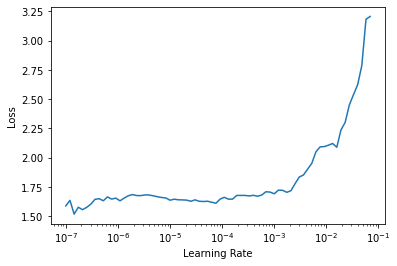

In [19]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(1, lr_max=7e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=1500)

We'll freeze all the layers with the exception of the decoder and classification_head layers (the last 2)

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(3, lr_max=slice(2e-8, 2e-7))

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=1500)

## Inference

In [ ]:
txt = tst_df.review_body[0]
print(txt)
learn.blurr_predict(txt)

In [ ]:
txts = list(tst_df.review_body.values[1:10])
print(txts)
learn.blurr_predict(txts)

Well that's it!  

I hope this article helps your fastai, huggingface, blurr out, and hey, if I'm doing something wrong above please let me know!  I'm far from perfect :)

For more information on the MBart/MBar-50 architecture, see the huggingface docs [here](https://huggingface.co/transformers/model_doc/mbart.html).